# Neural Network Hyperparameters

This tutorial provides code that helps experimenting with different neural network hyperparameters.

In [10]:
# Import keras and other functionality
from tensorflow import keras
from tensorflow import random
from keras.callbacks import EarlyStopping, ModelCheckpoint

keras.backend.clear_session()
random.set_seed(42)

In [11]:
# Load Fashion MNIST data
fashion_mnist = keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

# Select 55,000 datapoints for training and 5,000 datapoints for validation
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [12]:
# Preprocess training and validation data
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

In [13]:
# Use early stopping to avoid wasting resources with unnecessary training
# Training will stop if validation loss does not improve for 5 epochs (patience)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Callback to save best model (according to validation loss)
name_model = 'keras_best_model.keras'
best_model = ModelCheckpoint(name_model, monitor='val_loss', mode='min', save_best_only=True)

call_backs=[early_stopping, best_model] 
# Choose optimiser
l_rate=0.000001
opt = keras.optimizers.SGD(learning_rate=l_rate)

In [14]:
# Define neural network in keras using specified hyperparameters
def build_and_train_model(n_hidden=2, n_neurons=[300,100], optimizer=keras.optimizers.SGD(learning_rate=0.01), i_shape=[28, 28], epochs=30, call_backs=[]):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=i_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons[layer], activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))
   
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=call_backs)

    return model, history

In [15]:
# Build and train model using specific hyperparameters
[model, history] = build_and_train_model(n_hidden=2, n_neurons=[300,100], optimizer=opt, i_shape=[28, 28], epochs=50, call_backs=[early_stopping, best_model])

Epoch 1/50
1719/1719 [==============================] - 4s 2ms/step - loss: 2.3619 - accuracy: 0.1289 - val_loss: 2.3616 - val_accuracy: 0.1338
Epoch 2/50
1719/1719 [==============================] - 4s 2ms/step - loss: 2.3558 - accuracy: 0.1311 - val_loss: 2.3553 - val_accuracy: 0.1358
Epoch 3/50
1719/1719 [==============================] - 4s 2ms/step - loss: 2.3498 - accuracy: 0.1333 - val_loss: 2.3491 - val_accuracy: 0.1374
Epoch 4/50
1719/1719 [==============================] - 3s 2ms/step - loss: 2.3438 - accuracy: 0.1359 - val_loss: 2.3430 - val_accuracy: 0.1406
Epoch 5/50
1719/1719 [==============================] - 4s 2ms/step - loss: 2.3379 - accuracy: 0.1380 - val_loss: 2.3369 - val_accuracy: 0.1422
Epoch 6/50
1719/1719 [==============================] - 3s 2ms/step - loss: 2.3321 - accuracy: 0.1400 - val_loss: 2.3310 - val_accuracy: 0.1454
Epoch 7/50
1719/1719 [==============================] - 4s 2ms/step - loss: 2.3264 - accuracy: 0.1428 - val_loss: 2.3251 - val_accuracy:

In [7]:
# Check model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


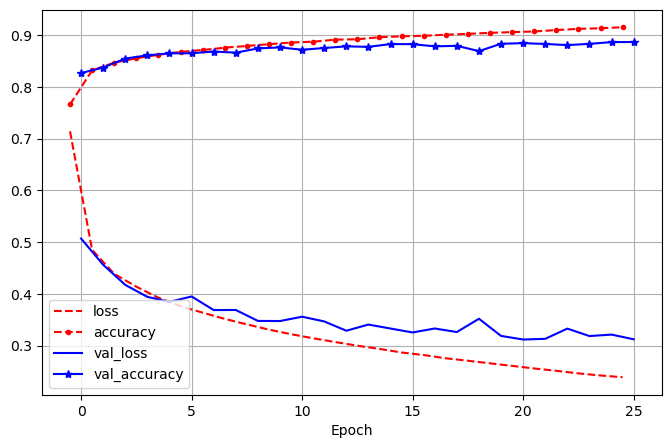

In [8]:
# Create function for plotting learning curves
import numpy as np
import matplotlib.pyplot as plt

def plot_curves(history):
    plt.figure(figsize=(8, 5))
    for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
        epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
        plt.plot(epochs, history.history[key], style, label=key)
    plt.xlabel("Epoch")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()

plot_curves(history)

In [9]:
# Load best model from training
saved_model = keras.models.load_model(name_model)

# Evaluate on the validation data (don't use test data if you are comparing different hyperparameters)
saved_model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 0.3117 - accuracy: 0.8848


[0.311710387468338, 0.8848000168800354]